In [1]:
# Imports & basic config
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import scipy.optimize as opt
from matplotlib.ticker import FuncFormatter

RNG = np.random.default_rng(42) # Set seed for reproducibility
trading_days = 252
rf = 0.035  # annual risk-free rate

In [2]:
# Data loading and preprocessing
def get_prices_and_logret(tickers, start='2010-01-01', auto_adjust=True):
    raw = yf.download(tickers, start=start, auto_adjust=auto_adjust)
    prices = raw['Close'].ffill().dropna()
    prices = prices.sort_index()
    logret = np.log(prices / prices.shift(1)).dropna()
    return prices, logret

# Stats
def compute_stats(logret, trading_days=252):
    mu = logret.mean() * trading_days
    cov = logret.cov() * trading_days
    ann_vol = pd.Series(np.sqrt(np.diag(cov.values)), index=logret.columns, name='ann_vol')
    return mu, cov, ann_vol

In [3]:
# Random portfolio sampling
def sample_random_portfolios(mu, cov, B=50000, alpha=0.3, rng=RNG):
    N = len(mu)
    W = rng.dirichlet([alpha] * N, size=B)
    ret = W @ mu.values
    vol = np.sqrt(np.einsum('bi,ij,bj->b', W, cov.values, W))
    sharpe = (ret - rf) / np.where(vol == 0, np.nan, vol)
    rand = pd.DataFrame({'ret': ret, 'vol': vol, 'sharpe': sharpe})
    rand['weights'] = list(W)
    return rand, W

In [4]:
# Portfolio metric helpers (accept mu,cov explicitly for clarity)
def port_ret(w, mu):
    return float(w @ mu.values)
def port_var(w, cov):
    return float(w @ cov.values @ w)
def port_vol(w, cov):
    return float(np.sqrt(port_var(w, cov)))
def neg_sharpe(w, mu, cov, rf_val=rf):
    v = port_vol(w, cov)
    return 1e6 if v == 0 else - (port_ret(w, mu) - rf_val) / v
def pretty_weights(w, tickers, top=20, pct=True):
    s = pd.Series(w, index=tickers).sort_values(ascending=False).head(top)
    return (s * 100).round(2) if pct else s

In [5]:
# Optimization: GMV and Tangency (long-only, fully invested)
def compute_gmv_and_tangency(mu, cov, rf_val=rf):
    tickers = list(mu.index)
    N = len(tickers)
    x0 = np.repeat(1.0 / N, N)
    bounds = [(0.0, 1.0)] * N
    cons_sum = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}

    res_gmv = opt.minimize(lambda w: w @ cov.values @ w, x0, method='SLSQP',
                           bounds=bounds, constraints=[cons_sum],
                           options={'ftol': 1e-12, 'maxiter': 20000})
    assert res_gmv.success, res_gmv.message
    w_gmv = res_gmv.x
    R_gmv = port_ret(w_gmv, mu)
    V_gmv = port_vol(w_gmv, cov)

    res_tan = opt.minimize(fun=lambda w: neg_sharpe(w, mu, cov, rf_val), x0=x0,
                           method='SLSQP', bounds=bounds, constraints=[cons_sum],
                           options={'ftol': 1e-12, 'maxiter': 20000})
    assert res_tan.success, res_tan.message
    w_tan = res_tan.x
    R_tan = port_ret(w_tan, mu)
    V_tan = port_vol(w_tan, cov)
    S_tan = (R_tan - rf_val) / V_tan if V_tan > 0 else np.nan
    return {
        'w_gmv': w_gmv, 'R_gmv': R_gmv, 'V_gmv': V_gmv,
        'w_tan': w_tan, 'R_tan': R_tan, 'V_tan': V_tan, 'S_tan': S_tan,
        'tickers': tickers
    }

In [6]:
# Efficient frontier builder (min variance for given returns)
def build_frontier(mu, cov, R_gmv, R_tan, w_tan, n_points=200):
    mu_ceiling = float(mu.max())
    r_lo = min(R_gmv, float(np.quantile(rand['ret'].values, 0.01))) if 'rand' in globals() else R_gmv
    r_hi = max(R_tan, float(np.quantile(rand['ret'].values, 0.995))) if 'rand' in globals() else R_tan
    r_hi = min(r_hi * 1.02, mu_ceiling * 0.995)
    targets = np.linspace(r_lo, r_hi, n_points)
    targets = np.unique(np.r_[targets, R_tan])
    frontier_vol = []
    frontier_ret = []
    frontier_w = []
    x0 = np.repeat(1.0 / len(mu), len(mu))
    bounds = [(0.0, 1.0)] * len(mu)
    cons_sum = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
    for tr in targets:
        cons_ret = {'type': 'eq', 'fun': lambda w, tr=tr: w @ mu.values - tr}
        res = opt.minimize(lambda w: w @ cov.values @ w, x0, method='SLSQP',
                           bounds=bounds, constraints=[cons_sum, cons_ret],
                           options={'ftol': 1e-12, 'maxiter': 40000})
        if res.success and abs(res.x.sum() - 1) < 1e-6 and res.x.min() >= -1e-10:
            w = res.x
            frontier_w.append(w)
            frontier_vol.append(np.sqrt(w @ cov.values @ w))
            frontier_ret.append(float(w @ mu.values))
            x0 = w
    return np.asarray(frontier_vol, float), np.asarray(frontier_ret, float), frontier_w

In [7]:
# Plotting helper for combined visual (cloud, frontier, GMV, tangency, CML)
def plot_frontier_and_cml(rand, frontier_vol, frontier_ret, opt_res, rf_val=rf):
    fv = np.asarray(frontier_vol, dtype=float).ravel()
    fr = np.asarray(frontier_ret, dtype=float).ravel()
    plt.figure(figsize=(9,6))
    if rand is not None:
        plt.scatter(rand['vol'], rand['ret'], s=6, alpha=0.2, label='Random Portfolios', color='blue')
    if fv.size > 0:
        order = np.argsort(fv)
        plt.plot(fv[order], fr[order], linewidth=2, label='Efficient Frontier')
    # GMV & Tangency
    plt.scatter([opt_res['V_gmv']], [opt_res['R_gmv']], s=110, marker='o', label='GMV', color='gold')
    plt.scatter([opt_res['V_tan']], [opt_res['R_tan']], s=160, marker='*', label='Max Sharpe', color='red')
    # CML
    slope = (opt_res['R_tan'] - rf_val) / opt_res['V_tan'] if opt_res['V_tan'] > 0 else 0.0
    ax = plt.gca()
    xmax = 1.05 * max(float(fv.max()) if fv.size else 0.0, float(rand['vol'].max()) if rand is not None else 0.0, float(opt_res['V_tan']))
    xs = np.linspace(0.0, xmax, 120)
    plt.plot(xs, rf_val + slope * xs, linestyle='--', linewidth=1.3, label='Capital Market Line')
    # risk-free
    plt.scatter([0.0], [rf_val], s=120, marker='o', color='black', label=f'Risk-free ({rf_val*100:.1f}%)')
    # format axes
    pct = FuncFormatter(lambda v, _: f'{v*100:.0f}%')
    ax.xaxis.set_major_formatter(pct)
    ax.yaxis.set_major_formatter(pct)
    plt.xlabel('Volatility (annual)')
    plt.ylabel('Return (annual)')
    plt.title('Efficient Frontier, GMV, Tangency and CML')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
# CML mixing utilities
def cml_mix_by_return(R_target, R_tan, V_tan, w_tan, rf_val=rf, allow_leverage=False):
    denom = (R_tan - rf_val)
    if denom <= 0:
        raise ValueError('Tangency return must exceed RF for CML mixing.')
    alpha = (R_target - rf_val) / denom
    if not allow_leverage:
        alpha = np.clip(alpha, 0.0, 1.0)
    w_rf = 1.0 - alpha
    w_risk = alpha * w_tan
    R = rf_val + alpha * (R_tan - rf_val)
    V = abs(alpha) * V_tan
    return w_rf, w_risk, float(R), float(V), float(alpha)

def cml_mix_by_vol(V_target, R_tan, V_tan, w_tan, rf_val=rf, allow_leverage=False):
    if V_tan <= 0:
        raise ValueError('Tangency volatility must be positive.')
    alpha = V_target / V_tan
    if not allow_leverage:
        alpha = np.clip(alpha, 0.0, 1.0)
    w_rf = 1.0 - alpha
    w_risk = alpha * w_tan
    R = rf_val + alpha * (R_tan - rf_val)
    V = abs(alpha) * V_tan
    return w_rf, w_risk, float(R), float(V), float(alpha)

def cml_table_by_return(target_returns, w_tan, R_tan, V_tan, rf_val=rf, allow_leverage=False, tickers=None):
    rows = []
    for Rt in np.asarray(target_returns, float):
        w_rf, w_risky, R, V, alpha = cml_mix_by_return(Rt, R_tan, V_tan, w_tan, rf_val=rf_val, allow_leverage=allow_leverage)
        row = {'R_target': Rt, 'R': R, 'V': V, 'alpha': alpha, 'w_RF': w_rf}
        if tickers is not None:
            row.update({t: w for t, w in zip(tickers, w_risky)})
        rows.append(row)
    return pd.DataFrame(rows)

[*********************100%***********************]  20 of 20 completed


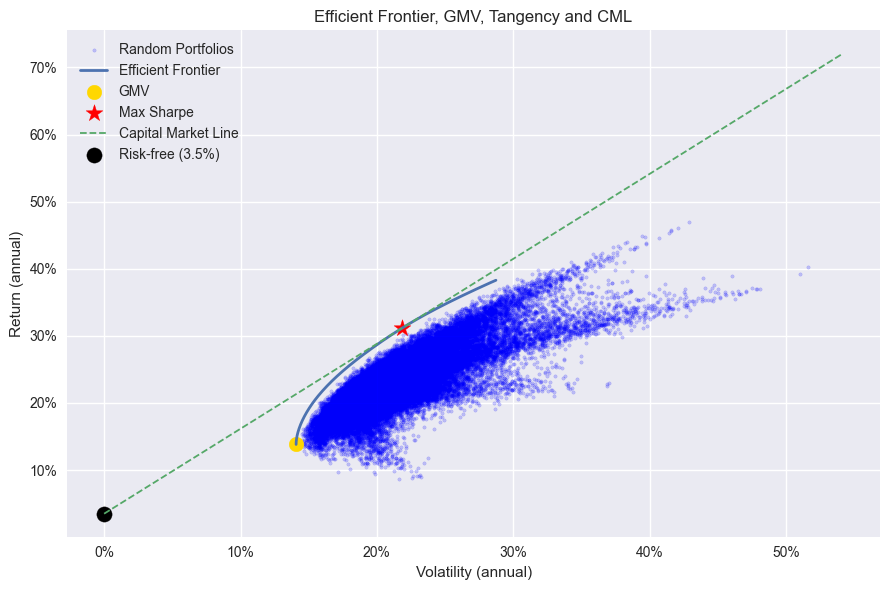

GMV: R=0.1382 V=0.1407
Tangency: R=0.3116 V=0.2184 Sharpe=1.267

Top weights (Tangency):
LLY     27.39
COST    26.47
NVDA    17.35
AVGO    14.64
NFLX     8.41
TSLA     4.19
JPM      1.29
WMT      0.25
AMZN     0.00
XOM      0.00


GMV: R=0.1382 V=0.1407
Tangency: R=0.3116 V=0.2184 Sharpe=1.267

Top weights (Tangency):
LLY     27.39
COST    26.47
NVDA    17.35
AVGO    14.64
NFLX     8.41
TSLA     4.19
JPM      1.29
WMT      0.25
XOM      0.00
AAPL     0.00


In [9]:
# RUN: minimal pipeline using the functions above
tickers = ['NVDA','MSFT','AAPL','AMZN','META','AVGO','GOOGL','TSLA','BRK-B','JPM','ORCL','WMT','LLY','V','MA','NFLX','XOM','COST','JNJ','HD']
prices, logret = get_prices_and_logret(tickers, start='2010-01-01')
mu, cov, ann_vol = compute_stats(logret, trading_days=trading_days)
rand, _W = sample_random_portfolios(mu, cov, B=50000, alpha=0.2)
opt_res = compute_gmv_and_tangency(mu, cov, rf_val=rf)
frontier_vol, frontier_ret, frontier_w = build_frontier(mu, cov, opt_res['R_gmv'], opt_res['R_tan'], opt_res['w_tan'], n_points=200)
plot_frontier_and_cml(rand, frontier_vol, frontier_ret, opt_res, rf_val=rf)
print('GMV:', f"R={opt_res['R_gmv']:.4f}", f"V={opt_res['V_gmv']:.4f}")
print('Tangency:', f"R={opt_res['R_tan']:.4f}", f"V={opt_res['V_tan']:.4f}", f"Sharpe={(opt_res['S_tan']):.3f}")
print('\nTop weights (Tangency):')
print(pretty_weights(opt_res['w_tan'], opt_res['tickers'], top=10).to_string())